# Library

In [7]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../ThreadAnalysis')
import PreProcessingText as ppt
from collections import Counter, defaultdict
import seaborn as sns
from wordcloud import WordCloud
import networkx as nx
import matplotlib.pyplot as plt
import squarify
from transformers import pipeline
from tqdm import tqdm
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer, util
from bertopic.representation import MaximalMarginalRelevance, KeyBERTInspired, PartOfSpeech
from sklearn.feature_extraction.text import CountVectorizer
from keybert import KeyBERT
from umap import UMAP
import hdbscan
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import csv
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.cluster import KMeans
from scipy.spatial import distance
from scipy.cluster import hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora
from itertools import combinations

c:\Users\dommy\miniconda3\envs\gestione\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dommy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dommy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dommy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


##

In [8]:
df = pd.read_csv('../merged_data.csv')
df = df.dropna(subset=['content'])
df = df.drop_duplicates(subset=['content'], keep='first')
df.shape[0]

270239

In [13]:
df['content'] = df['content'].apply(ppt.clean_sentences)

In [19]:
df.to_csv('content_clean_sentences.csv', index=False)
df_unique = pd.DataFrame(df['content'].unique())
df_unique.to_csv('only_content_clean_sentences.csv', index=False, header=False)

In [18]:
df['content'] = df['content'].apply(ppt.preprocess_title)
df['content'] = df['content'].apply(ppt.remove_single_characters)
df['content'].value_counts()

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')
tc1 = ppt.TextClustering(df, 'content')
tc1.encode_corpus(model, batch_size=64, to_tensor=False)

In [117]:
mmr = MaximalMarginalRelevance(diversity=0.3)
kw = KeyBERTInspired()
vectorizer_model = CountVectorizer(stop_words="english")
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
umap_model = UMAP(n_neighbors=80, n_components=10, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=600, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

topic_model = BERTopic(
    top_n_words=10, 
    n_gram_range=(1, 2),
    umap_model=umap_model, 
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model, 
    ctfidf_model=ctfidf_model, 
    representation_model=[mmr, kw],
    embedding_model=model,
    calculate_probabilities=True,
    verbose=True
)

topics, probs = topic_model.fit_transform(tc1.corpus, tc1.corpus_embeddings)

2024-06-30 15:40:03,123 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-06-30 15:42:22,877 - BERTopic - Dimensionality - Completed ✓
2024-06-30 15:42:22,905 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-06-30 15:43:23,274 - BERTopic - Cluster - Completed ✓
2024-06-30 15:43:23,475 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-06-30 15:44:03,645 - BERTopic - Representation - Completed ✓


In [118]:
vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 5))
topic_model.update_topics(tc1.corpus, vectorizer_model=vectorizer_model)

In [119]:
topic_model.get_topic_info()

Topic  Count                                               Name  \
0      -1  24995                        -1_vendor_review_market_new   
1       0   4998                           0_weed_cannabis_cart_thc   
2       1   1948                                1_help_need_guy_sub   
3       2   1845                      2_order_shipping_package_pack   
4       3   1728        3_empire_empire market_empire empire_market   
..    ...    ...                                                ...   
64     63    191                    63_dmt_dmt vendor_odsmt_dmt dmt   
65     64    186  64_captcha_rapture_rapture market_captcha captcha   
66     65    181       65_chemical_research_research chemical_chems   
67     66    166             66_tor_browser_tor browser_tor network   
68     67    159                 67_mephedrone_meopcp_mxe_mescaline   

                                       Representation  \
0   [vendor, review, market, new, order, account, ...   
1   [weed, cannabis, cart, thc, review, oz, hash, ...   
2   [help, need, guy, sub, day, question, post, ad...   
3   [order, shipping, package, pack, delivery, shi...   
4   [empire, empire market, empire empire, market,...   
..                                                ...   
64  [dmt, dmt vendor, odsmt, dmt dmt, bluefairy, c...   
65  [captcha, rapture, rapture market, captcha cap...   
66  [chemical, research, research chemical, chems,...   
67  [tor, browser, tor browser, tor network, netwo...   
68  [mephedrone, meopcp, mxe, mescaline, mmc, meph...   

                                  Representative_Docs  
0   [review vendor cdnven product china white synt...  
1   [product vendor review ml lemon kush wax vape ...  
2   [hi guy update post, way make sub like old red...  
3   [package show informed delivery, usps informed...  
4   [empire back, empire market back, empire suppo...  
..                                                ...  
64                 [best dmt vendor, dmt, vendor dmt]  
65  [captcha, use rapture registration login captc...  
66  [chem theory honorable research chemical suppl...  
67  [tor browser help, review tor browser, tor bro...  
68  [eurovalz new stock list mxe mephedrone availa...  

[69 rows x 5 columns]

In [120]:
umap_embeddings = topic_model.umap_model.fit_transform(tc1.corpus_embeddings)
indices = [index for index, topic in enumerate(topics) if topic != -1]
X=umap_embeddings[np.array(indices)]
labels = [topic for index, topic in enumerate(topics) if topic != -1]
silhouette_scores = silhouette_score(X, labels)
print(f"silhouette_score: {silhouette_scores}")
print(f"Davies_bouldin_score: {davies_bouldin_score(X, labels)}")

silhouette_score: 0.6823439598083496
Davies_bouldin_score: 0.3791311194398217


In [136]:
new_topics = topic_model.reduce_outliers(tc1.corpus, topics, strategy="embeddings", embeddings=tc1.corpus_embeddings, threshold=0.46)
topic_model.update_topics(tc1.corpus, topics=new_topics)
topic_model.get_topic_info()

2024-06-30 16:01:57,452 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Topic  Count                                               Name  \
0      -1  18900                        -1_anyone_get_update_review   
1       0   5021                           0_weed_cannabis_cart_thc   
2       1   2035                                1_help_guy_sub_need   
3       2   2005                      2_order_shipping_package_pack   
4       3   1815        3_empire_empire market_empire empire_market   
..    ...    ...                                                ...   
64     63    202                   63_dmt_dmt vendor_dmt vape_odsmt   
65     64    187  64_captcha_rapture_rapture market_captcha captcha   
66     65    198       65_chemical_research_research chemical_chems   
67     66    222             66_tor_tor browser_browser_tor network   
68     67    178                 67_mephedrone_meopcp_mxe_mescaline   

                                       Representation  \
0   [anyone, get, update, review, new, order, acco...   
1   [weed, cannabis, cart, thc, review, hash, shat...   
2   [help, guy, sub, need, back, question, day, ad...   
3   [order, shipping, package, pack, delivery, shi...   
4   [empire, empire market, empire empire, market,...   
..                                                ...   
64  [dmt, dmt vendor, dmt vape, odsmt, dmt dmt, ch...   
65  [captcha, rapture, rapture market, captcha cap...   
66  [chemical, research, research chemical, chems,...   
67  [tor, tor browser, browser, tor network, netwo...   
68  [mephedrone, meopcp, mxe, mescaline, mmc, meph...   

                                  Representative_Docs  
0   [review vendor cdnven product china white synt...  
1   [product vendor review ml lemon kush wax vape ...  
2   [hi guy update post, way make sub like old red...  
3   [package show informed delivery, usps informed...  
4   [empire back, empire market back, empire suppo...  
..                                                ...  
64                 [best dmt vendor, dmt, vendor dmt]  
65  [captcha, use rapture registration login captc...  
66  [chem theory honorable research chemical suppl...  
67  [tor browser help, review tor browser, tor bro...  
68  [eurovalz new stock list mxe mephedrone availa...  

[69 rows x 5 columns]

In [137]:
for topic_id in set(topics):
    print(f"Topic {topic_id}:")
    print(topic_model.get_topic(topic_id))

Topic 0:
[('weed', 0.034440655421142205), ('cannabis', 0.02163153800597487), ('cart', 0.02131043599512726), ('thc', 0.01824969706580151), ('review', 0.014699009276947663), ('hash', 0.013941473812216146), ('shatter', 0.01385956329618397), ('distillate', 0.013788654857474974), ('oz', 0.013699156416790433), ('bud', 0.013511109713200431)]
Topic 1:
[('help', 0.020902783340739296), ('guy', 0.018141447515630817), ('sub', 0.018061502588594965), ('need', 0.017228855503283312), ('back', 0.015478023601901827), ('question', 0.014588537674805049), ('day', 0.014103368936720316), ('advice', 0.013364282528612713), ('shit', 0.01315161003792278), ('post', 0.013047995251142981)]
Topic 2:
[('order', 0.05141015231966171), ('shipping', 0.049459163735666216), ('package', 0.034053136968648846), ('pack', 0.03022209818441062), ('delivery', 0.02795081519396416), ('shipped', 0.02329856657883124), ('ship', 0.018460022471923705), ('usps', 0.01791841479902273), ('delivered', 0.013805279333056695), ('international', 

In [138]:
topic_model.visualize_topics()

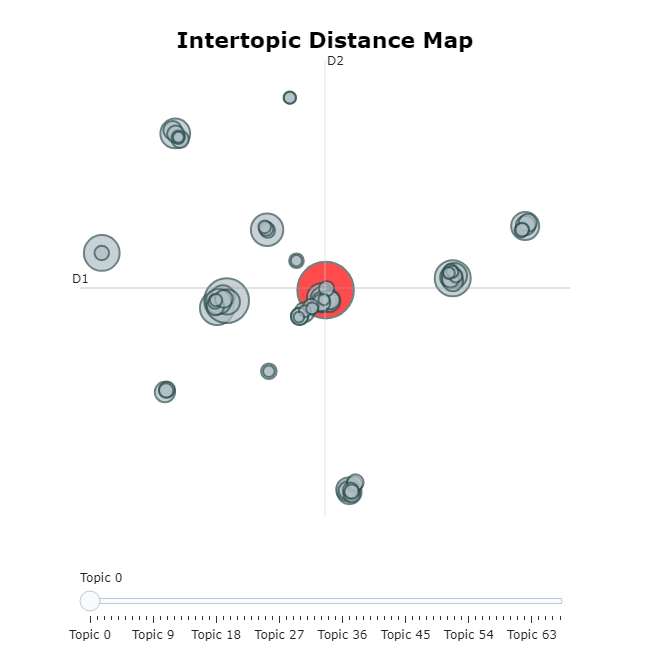

In [139]:
umap_embeddings = topic_model.umap_model.fit_transform(tc1.corpus_embeddings)
indices = [index for index, topic in enumerate(new_topics) if topic != -1]
X=umap_embeddings[np.array(indices)]
labels = [topic for index, topic in enumerate(new_topics) if topic != -1]
silhouette_scores = silhouette_score(X, labels)
print(f"silhouette_score: {silhouette_scores}")
print(f"Davies_bouldin_score: {davies_bouldin_score(X, labels)}")

silhouette_score: 0.48274117708206177
Davies_bouldin_score: 0.8687026513069406


In [140]:
topic_words = topic_model.get_topics()
topics_ll = [topic_words[i] for i in range(len(topic_words) - 1) if i != -1]

topn = 10
topic_list = []
for topic in topics_ll:
    topic_list.append([word for word, _ in topic[:topn]])

coherence_model = CoherenceModel(
    topics=topic_list,
    texts=[doc.split() for doc in tc1.corpus],
    dictionary=corpora.Dictionary([doc.split() for doc in tc1.corpus]),
    coherence='c_v'
)

print(f"Coherence Model: {coherence_model.get_coherence()}")

Coherence Model: 0.5645685188607535


In [89]:
def calculate_dos(topic_words, top_n=10):
    """
    Calculate the average overlap score for all pairs of topics.
    :param topic_words: The topic words
    :param top_n: The number of words to consider for each topic
    :return: The average overlap score
    """
    overlap = 0
    num_combinations = 0
    for topic1, topic2 in combinations(topic_words.values(), 2):
        words1 = set([word for word, _ in topic1[:top_n]])
        words2 = set([word for word, _ in topic2[:top_n]])
        overlap += len(words1.intersection(words2))
        num_combinations += 1
    return overlap / num_combinations

In [92]:
dos_score = calculate_dos(topic_model.get_topics())
print(f"Distinta Overlap Score: {dos_score}")

Distinta Overlap Score: 0.06308610400682012


In [ ]:
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

In [189]:
zero_shot_topics = pd.read_csv('../../../intent_crime.csv')['intent'].tolist()
dict_zero_shots_25 = ppt.assign_labels_to_topics(classifier, topic_model, zero_shot_topics, len(set(new_topics) - {-1}), threshold=.25)

Assigning labels to topics:   0%|          | 0/68 [00:00<?, ?it/s]

Assigning labels to topics: 100%|██████████| 68/68 [42:46<00:00, 37.74s/it] 


In [232]:
dict_zero_shots_25 = pd.read_csv('ZeroShotClassificationResults/all-MiniLM-L6-v2_150_20n/zero_shot_025.csv').set_index('Topic')['Labels'].to_dict()

In [ ]:
dict_zero_shots_25[1] = 'ask help - ask help post'
dict_zero_shots_25[2] = 'order'
dict_zero_shots_25[10] = 'crosspost vendor'
dict_zero_shots_25[13] = 'dream market - dread'
dict_zero_shots_25[14] = 'ask help - moderator'
dict_zero_shots_25[15] = 'cocaine vendor - cocaine'
dict_zero_shots_25[20] = 'bunk bar'
dict_zero_shots_25[28] = 'wsm vendor - wsm market'
dict_zero_shots_25[39] = 'cryptonia market - dread'
dict_zero_shots_25[41] = 'escrow service'
dict_zero_shots_25[48] = 'event happened'
dict_zero_shots_25[51] = 'dream - dream vendor - dread'
dict_zero_shots_25[52] = 'order cancelled'
dict_zero_shots_25[57] = 'opsec questions'
dict_zero_shots_25[58] = 'link'
dict_zero_shots_25[59] = 'mirror - mirror link - working mirror'
dict_zero_shots_25[64] = 'capcha'

In [ ]:
pd.DataFrame(list(dict_zero_shots_25.items()), columns=['Topic', 'Labels']).to_csv('ZeroShotClassificationResults/all-MiniLM-L6-v2_150_20n/zero_shot_025.csv', index=False)

In [235]:
topic_model.set_topic_labels(dict_zero_shots_25)

In [236]:
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, 
                          min_dist=0.0, metric='cosine').fit_transform(tc1.corpus_embeddings)
topic_model.visualize_documents(tc1.corpus, reduced_embeddings=reduced_embeddings, 
                                hide_document_hover=True, hide_annotations=True, custom_labels=True)

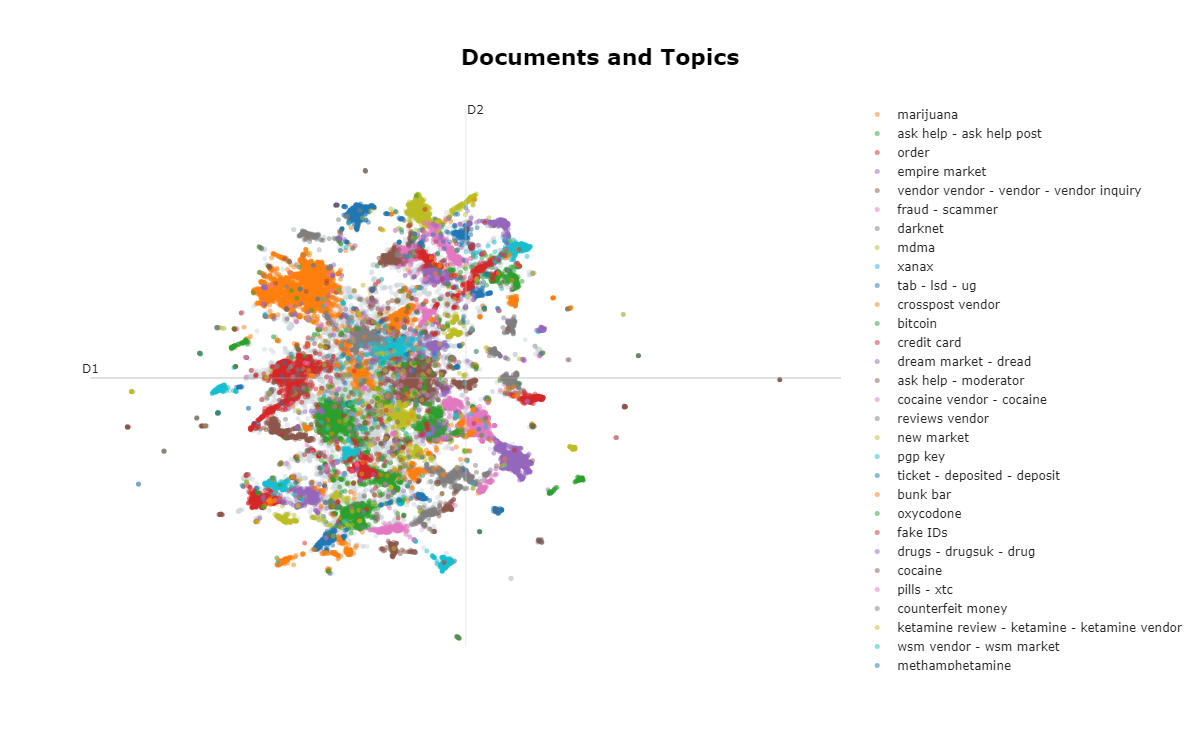

In [ ]:
topic_model.visualize_barchart(top_n_topics=70, custom_labels=True, n_words=10)

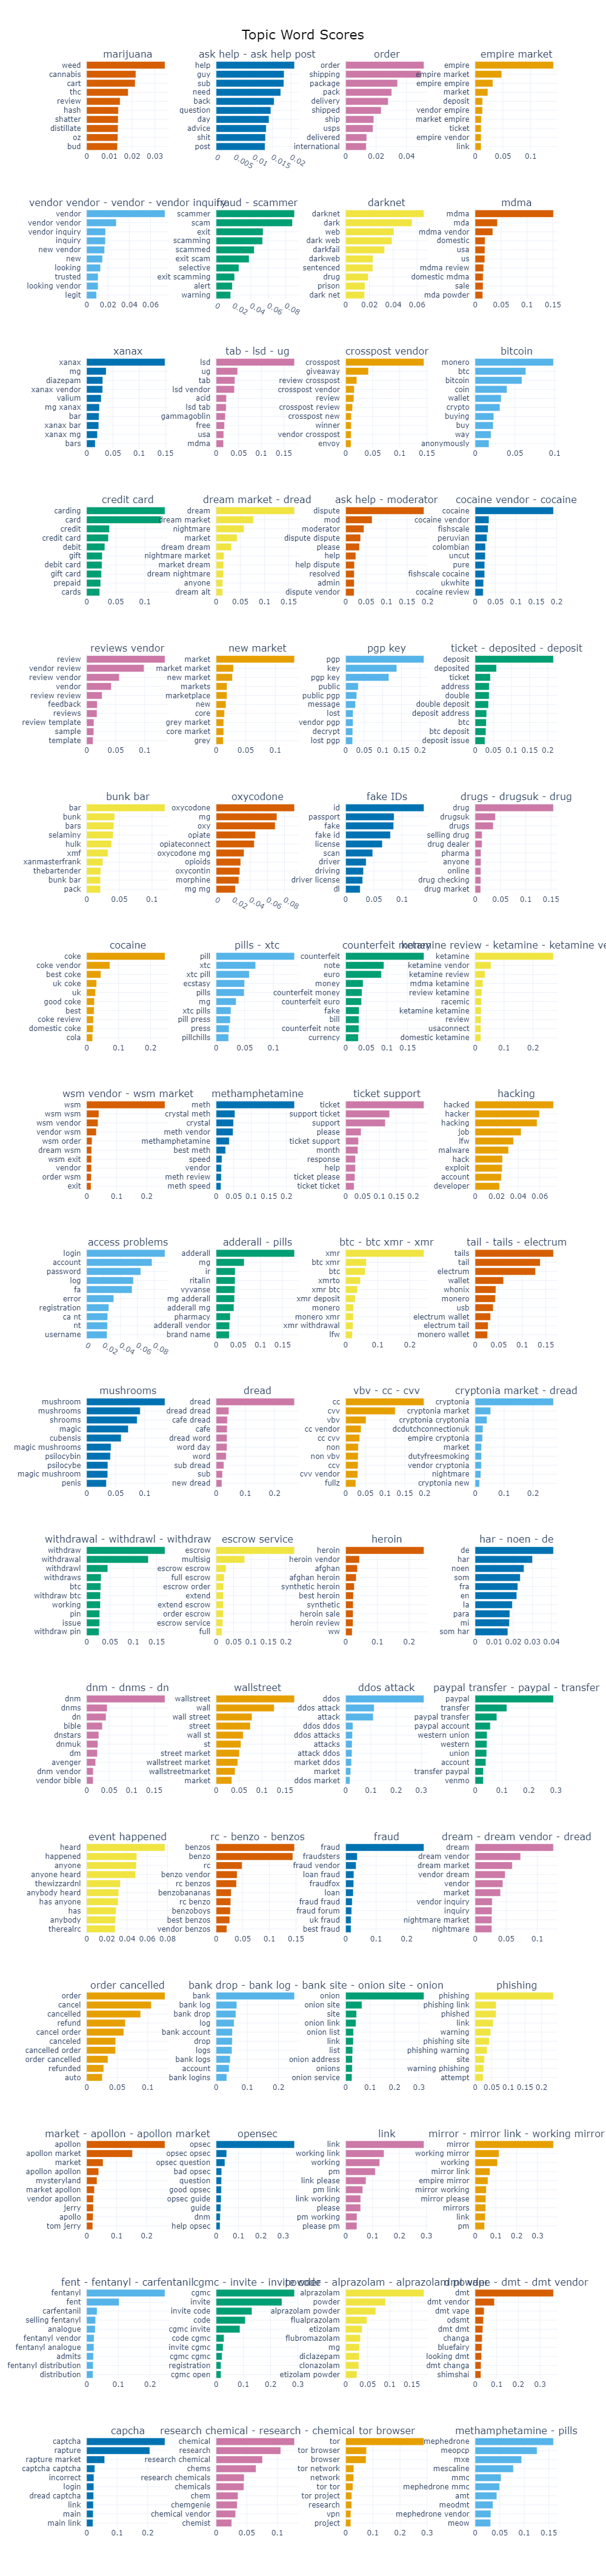

In [ ]:
topic_model.visualize_hierarchy(custom_labels=True)

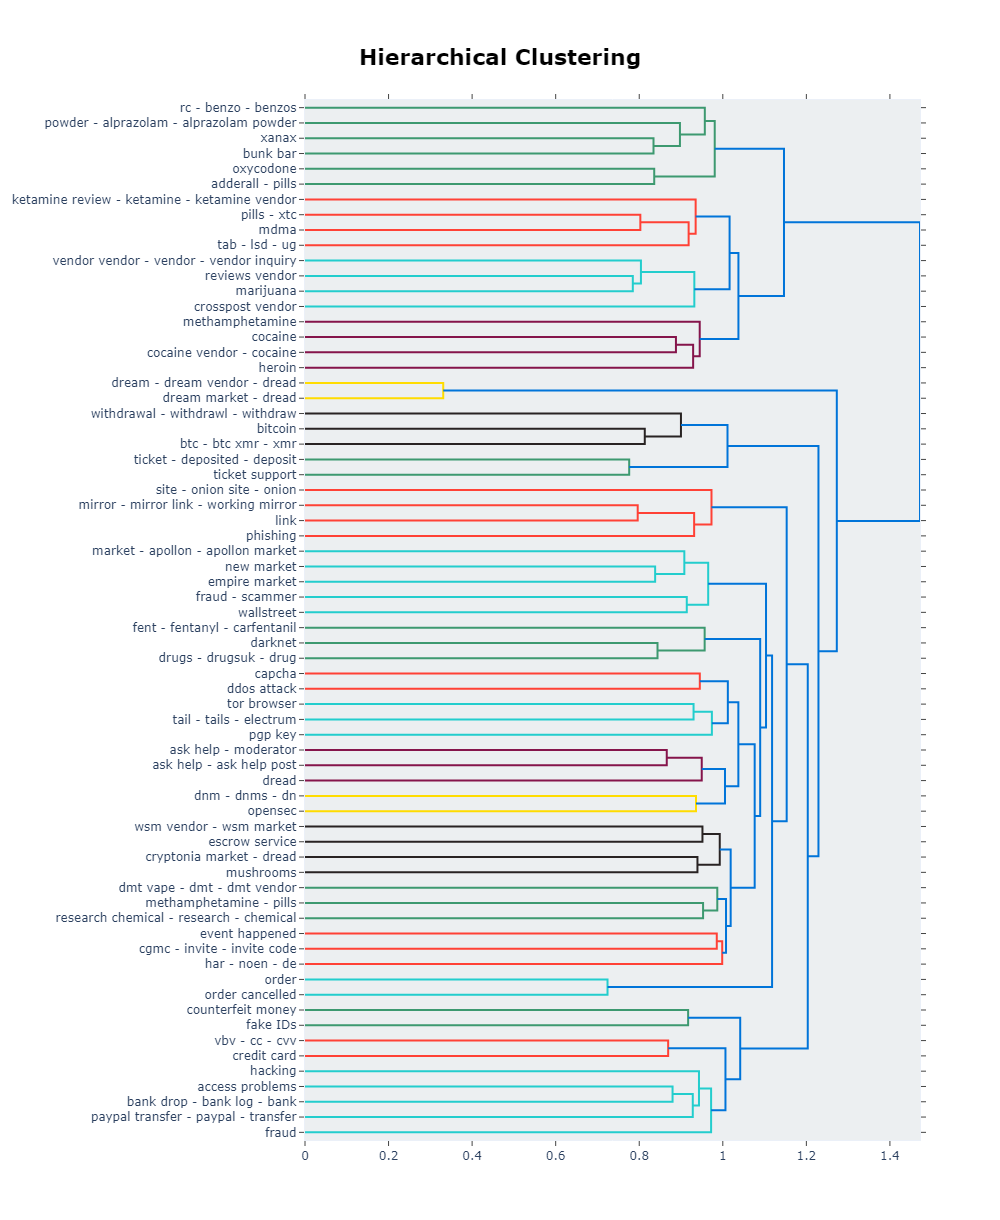

In [5]:
topic_model.visualize_heatmap(custom_labels=True)

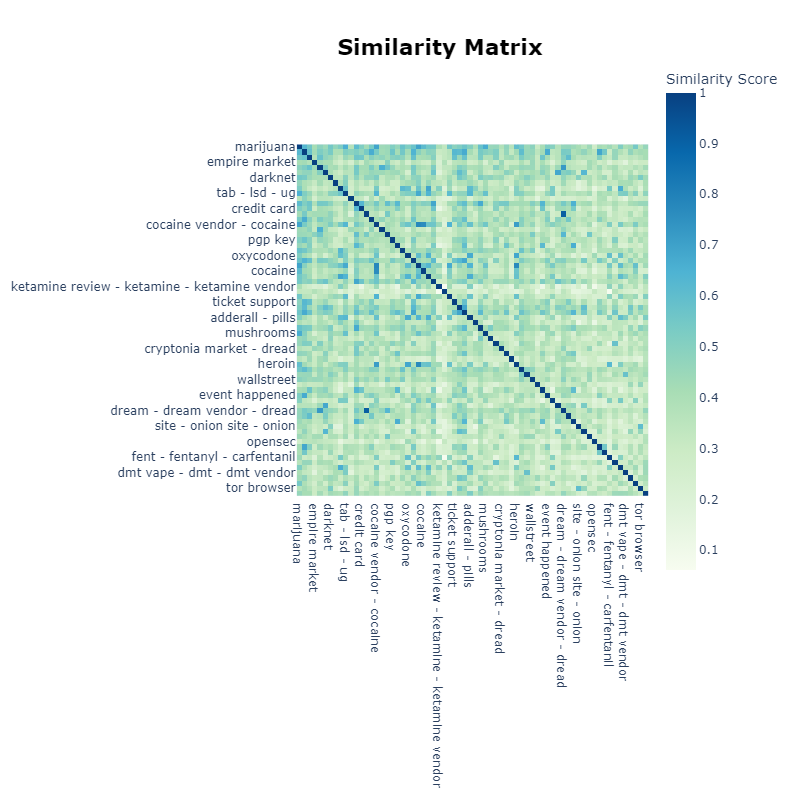

In [239]:
topics_over_time = topic_model.topics_over_time(tc1.corpus, created_on, 
                                                global_tuning=True, evolution_tuning=True, nr_bins=100)
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=10, width=1250, height=700, custom_labels=True)

15it [00:22,  1.52s/it]


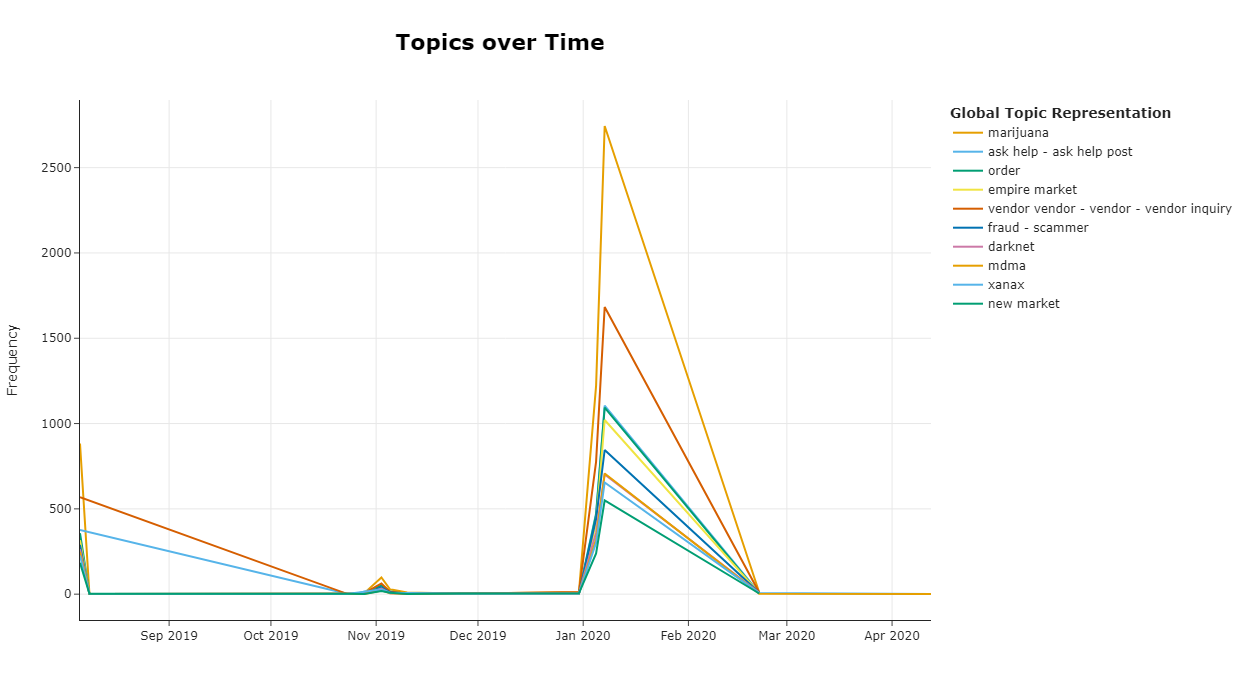

In [240]:
df['name_thread'] = df['name_thread'].str.lower().dropna()
df.drop_duplicates(subset='name_thread', inplace=True)
df.dropna(subset=['name_thread'], inplace=True)
created_on = df['created_on'].tolist()
indices = [index for index, topic in enumerate(new_topics) if topic != -1]
corpus_valid = [tc1.corpus[i] for i in indices]
created_on_valid = [created_on[i] for i in indices]
embeddings_valid = [tc1.corpus_embeddings[i] for i in indices]
topics_valid = [new_topics[i] for i in indices]
probs_valid = [probs[i] for i in indices]

results = pd.DataFrame({
    'Document': corpus_valid,
    'Embedding': embeddings_valid,
    'Topic': topics_valid,
    'Probability': probs_valid,
    'Created_on': created_on_valid,
})
results_final = pd.merge(results, topic_model.get_topic_info(), on='Topic')
print(results_final.shape)
results_final.head()

(46629, 10)


Document  \
0                                naturalmeds apollon   
1  redemption btc giveaway coke sub dread member ...   
2                      flubromazolam sample giveaway   
3                          cigarette tobacco replica   
4                       requiring image image review   

                                           Embedding  Topic  \
0  [-0.11246682, -0.03748099, 0.04490077, 0.01724...     56   
1  [-0.043700494, -0.032600075, 0.0051953266, 0.0...     24   
2  [-0.04101017, 0.007629349, -0.07528322, -0.033...     62   
3  [-0.07527819, 0.13146353, -0.07912154, -0.0353...      0   
4  [-0.014864997, 0.08211257, 0.004136639, 0.0027...     16   

                                         Probability  Created_on  Count  \
0  [1.1964202652021368e-307, 6.589650224023648e-3...  2020-01-09    242   
1  [0.006596099708564405, 0.003763170646085399, 0...  2020-01-09    544   
2  [8.335712654832696e-308, 7.430095287264378e-30...  2019-11-06    290   
3  [0.040079176553298505, 0.007976173889767435, 0...  2020-01-09   5021   
4  [0.006753134223967767, 0.007309909359113744, 0...  2019-11-06    998   

                                                Name  \
0   56_apollon_apollon market_market_apollon apollon   
1              24_coke_coke vendor_best coke_uk coke   
2  62_alprazolam_powder_alprazolam powder_flualpr...   
3                           0_weed_cannabis_cart_thc   
4       16_review_vendor review_review vendor_vendor   

                                CustomName  \
0        market - apollon - apollon market   
1                                  cocaine   
2  powder - alprazolam - alprazolam powder   
3                                marijuana   
4                           reviews vendor   

                                      Representation  \
0  [apollon, apollon market, market, apollon apol...   
1  [coke, coke vendor, best coke, uk coke, uk, go...   
2  [alprazolam, powder, alprazolam powder, flualp...   
3  [weed, cannabis, cart, thc, review, hash, shat...   
4  [review, vendor review, review vendor, vendor,...   

                                 Representative_Docs  
0            [back apollon, apollon, apollon market]  
1             [fire coke, coke vendor , coke vendor]  
2  [usa domestic alprazolam powder mxe apvp inbom...  
3  [product vendor review ml lemon kush wax vape ...  
4  [xpost danknation vendor review sunaero multis...

In [241]:
results_final.to_parquet('ResultsBERTopic/BERTopic_all-MiniLM-L6-v2_150_20n.parquet')

In [ ]:
topic_model.save("Models/topic_model_all-MiniLM-L6-v2_150_20n", serialization="pickle", save_ctfidf=True, save_embedding_model=model)

In [243]:
topic_model.save("Models/topic_model_all-MiniLM-L6-v2_150_20n_safetensors", serialization="safetensors", save_ctfidf=True, save_embedding_model=model)

In [69]:
topic_model = BERTopic.load("Models/topic_model_all-MiniLM-L6-v2_150_20n")

In [244]:
sentence = ['recently closed Samsara market']
tp, pr = topic_model.transform(sentence)

Batches: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]
2024-06-30 21:54:03,236 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2024-06-30 21:54:08,543 - BERTopic - Dimensionality - Completed ✓
2024-06-30 21:54:08,544 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2024-06-30 21:54:08,576 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2024-06-30 21:54:08,699 - BERTopic - Probabilities - Completed ✓
2024-06-30 21:54:08,701 - BERTopic - Cluster - Completed ✓


In [248]:
top_indices = np.argsort(pr[0])[::-1][:5]
top_topics = [(topic_model.get_topic(i), pr[0][i], topic_model.custom_labels_[i+1]) for i in top_indices]
df_finals = pd.DataFrame(top_topics, columns=['Topic', 'Probability', 'Label'])
df_finals['Words'] = df_finals['Topic'].apply(lambda topic: [word for word, prob in topic])
df_finals['Sentence'] = sentence * len(df_finals)
df_finals

Topic  Probability  \
0  [(cryptonia, 0.270593329016721), (cryptonia ma...     0.002991   
1  [(empire, 0.1408905571475779), (empire market,...     0.002262   
2  [(wallstreet, 0.17075397467717646), (wall, 0.1...     0.002127   
3  [(scammer, 0.09029491748260987), (scam, 0.0879...     0.002075   
4  [(crosspost, 0.14470709618860572), (giveaway, ...     0.002045   

                      Label  \
0  cryptonia market - dread   
1             empire market   
2                wallstreet   
3           fraud - scammer   
4          crosspost vendor   

                                               Words  \
0  [cryptonia, cryptonia market, cryptonia crypto...   
1  [empire, empire market, empire empire, market,...   
2  [wallstreet, wall, wall street, street, wall s...   
3  [scammer, scam, exit, scamming, scammed, exit ...   
4  [crosspost, giveaway, review crosspost, crossp...   

                         Sentence  
0  recently closed Samsara market  
1  recently closed Samsara market  
2  recently closed Samsara market  
3  recently closed Samsara market  
4  recently closed Samsara market

In [109]:
topic_model.get_topic(tp[0])

[('anyone', 0.009415205712082564),
 ('update', 0.007916840604830654),
 ('address', 0.006939392479966835),
 ('new', 0.006268540212828576),
 ('get', 0.006179372827051399),
 ('vacation', 0.0059803996923821),
 ('has', 0.0058347636749867746),
 ('need', 0.005401699096715211),
 ('drop', 0.005394598005495695),
 ('listing', 0.005367223382048893)]